# Feature Importance


## Einlesen von Packages und setzen von Variablen / Funktionen

In [1]:
import sys
import os

parentdir = os.path.dirname(os.path.abspath(''))
sys.path.append(parentdir)

from datetime import date

import pandas as pd
import numpy as np

import pandas_profiling as pd_profil

import functions as fu
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


%matplotlib inline

# Pfade setzen
c_fold = fu.get_folder()
p_fold = c_fold + '\data\Prepared'
folder = c_fold + '\data\Processed\Zyklus'
folder_final = c_fold + '\data\Processed\\final'

# y = df.loc[:, df.columns.isin(['amperestunden'])]
# X = df.loc[:, ~df.columns.isin(['amperestunden'])]

## Daten einlesen und erste Übersicht erzeugen

In [2]:
daten = pd.read_csv(f"{folder_final}\\df_fertige_features_ref_discharge.csv", sep=',')
daten.drop(["batteryname_","comment_","type_"], axis=1, inplace=True) #brauch ich hier nicht
daten.drop(["time_amin"], axis=1, inplace=True) #zu viel überschneidung mit *_leicht_vorher

In [3]:
daten.head(1)

,amperestunden,zyklus_,temperature_amax,temperature_amin,temperature_mean,time_entladen_stark_vorher,time_entladen_leicht_vorher,time_laden_stark_vorher,time_laden_leicht_vorher,time_pause_vorher,time_temp_hoch_vorher
0,2.000364,3,23.56742,18.39025,21.798768,0.0,196178.5,0.0,194718.28,0.0,0.0


In [4]:
daten.describe().T

,count,mean,std,min,25%,50%,75%,max
amperestunden,950.0,1.501489e+00,3.325745e-01,0.00000,1.253412e+00,1.491576e+00,1.754461e+00,2.147193e+00
zyklus_,950.0,2.821897e+04,2.832191e+04,1.00000,7.952750e+03,1.607300e+04,3.951125e+04,1.135760e+05
temperature_amax,950.0,-3.431336e+02,1.183821e+03,-4099.44775,2.464716e+01,2.705985e+01,3.433386e+01,4.493351e+01
temperature_amin,950.0,-3.692756e+02,1.212789e+03,-4099.44775,1.948107e+01,2.180882e+01,2.856798e+01,4.065417e+01
temperature_mean,950.0,-3.627267e+02,1.206597e+03,-4099.44775,2.231614e+01,2.449825e+01,3.168772e+01,4.214114e+01
time_entladen_stark_vorher,950.0,2.050139e+05,1.235054e+05,0.00000,1.230087e+05,2.033745e+05,2.643114e+05,5.931812e+05
time_entladen_leicht_vorher,950.0,1.358084e+06,1.094643e+06,7538.12000,4.689968e+05,1.105875e+06,1.896082e+06,4.347433e+06
time_laden_stark_vorher,950.0,4.752963e+04,7.702572e+04,0.00000,0.000000e+00,0.000000e+00,9.816928e+04,2.416744e+05
time_laden_leicht_vorher,950.0,3.649026e+06,2.470854e+06,1627.08000,1.667121e+06,3.387895e+06,5.026416e+06,1.085041e+07
time_pause_vorher,950.0,1.050077e+06,1.183727e+06,0.00000,1.291394e+05,6.488780e+05,1.504034e+06,5.585429e+06


Saving figure features_histogram_plots


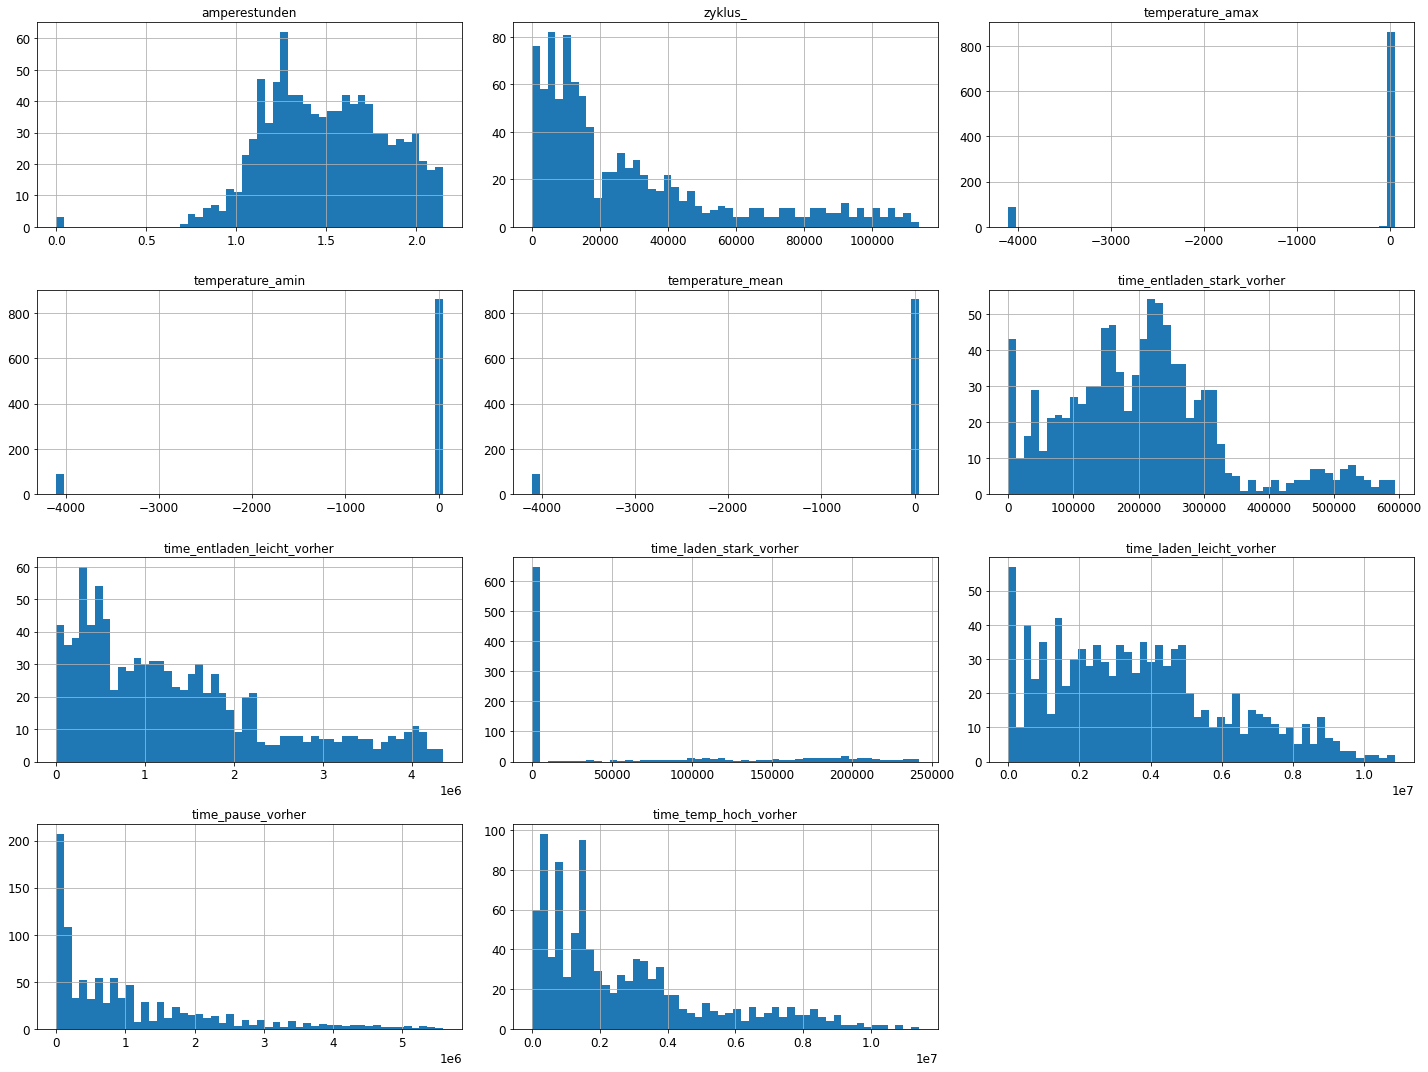

In [5]:
daten.hist(bins=50, figsize=(20,15))
fu.save_fig("features_histogram_plots")
plt.show()

# Ausreißer

* Temperatur hat Ausreißer in die -4000° Region. Die Werte sollten ersetzt werden durch den Median des Rests
* Es scheint die Werte unterhalb des 10% Percentils zu betreffen

In [6]:
daten[["temperature_amax","temperature_amin",'temperature_mean']].describe(percentiles=[.01, .05, .06, .07, .08, .09, .10, .25]).T

,count,mean,std,min,1%,5%,6%,7%,8%,9%,10%,25%,50%,max
temperature_amax,950.0,-343.133612,1183.820648,-4099.44775,-4094.09814,-4093.927,-4093.927,-4093.927,-4093.927,-2423.868635,22.915359,24.647160,27.059845,44.933510
temperature_amin,950.0,-369.275580,1212.788638,-4099.44775,-4094.09814,-4093.927,-4093.927,-4093.927,-4093.927,-4093.927000,17.529249,19.481068,21.808820,40.654170
temperature_mean,950.0,-362.726664,1206.597105,-4099.44775,-4094.09814,-4093.927,-4093.927,-4093.927,-4093.927,-4059.537600,20.756119,22.316141,24.498245,42.141144


In [7]:
daten_ohne_aus = daten.copy()
spalten_mit_ausreißern = ["temperature_amax","temperature_amin",'temperature_mean']
for spalte in spalten_mit_ausreißern:
    neuer_wert = daten_ohne_aus[daten_ohne_aus[spalte] > np.percentile(daten_ohne_aus[spalte],10)][spalte].median() #ersetzen durch den Median der Restwerte
    daten_ohne_aus.loc[daten_ohne_aus[spalte] < np.percentile(daten_ohne_aus[spalte],10),spalte] = neuer_wert #neuen Wert setzen


In [8]:
daten_ohne_aus[["temperature_amax","temperature_amin",'temperature_mean']].describe(percentiles=[.01, .05, .06, .07, .08, .09, .10, .25]).T

,count,mean,std,min,1%,5%,6%,7%,8%,9%,10%,25%,50%,max
temperature_amax,950.0,30.345366,6.094273,22.926070,23.381395,23.909873,24.037476,24.106315,24.199473,24.261744,24.309977,25.619230,27.855480,44.933510
temperature_amin,950.0,25.007313,6.274912,17.532010,17.850291,18.526055,18.691482,18.821656,18.870370,19.001685,19.066419,20.202535,22.487800,40.654170
temperature_mean,950.0,27.926257,6.120999,20.769734,21.023817,21.689316,21.755543,21.814093,21.855010,21.919078,22.008876,23.160582,25.432371,42.141144


Saving figure features_histogram_plots_ohne_ausreißer


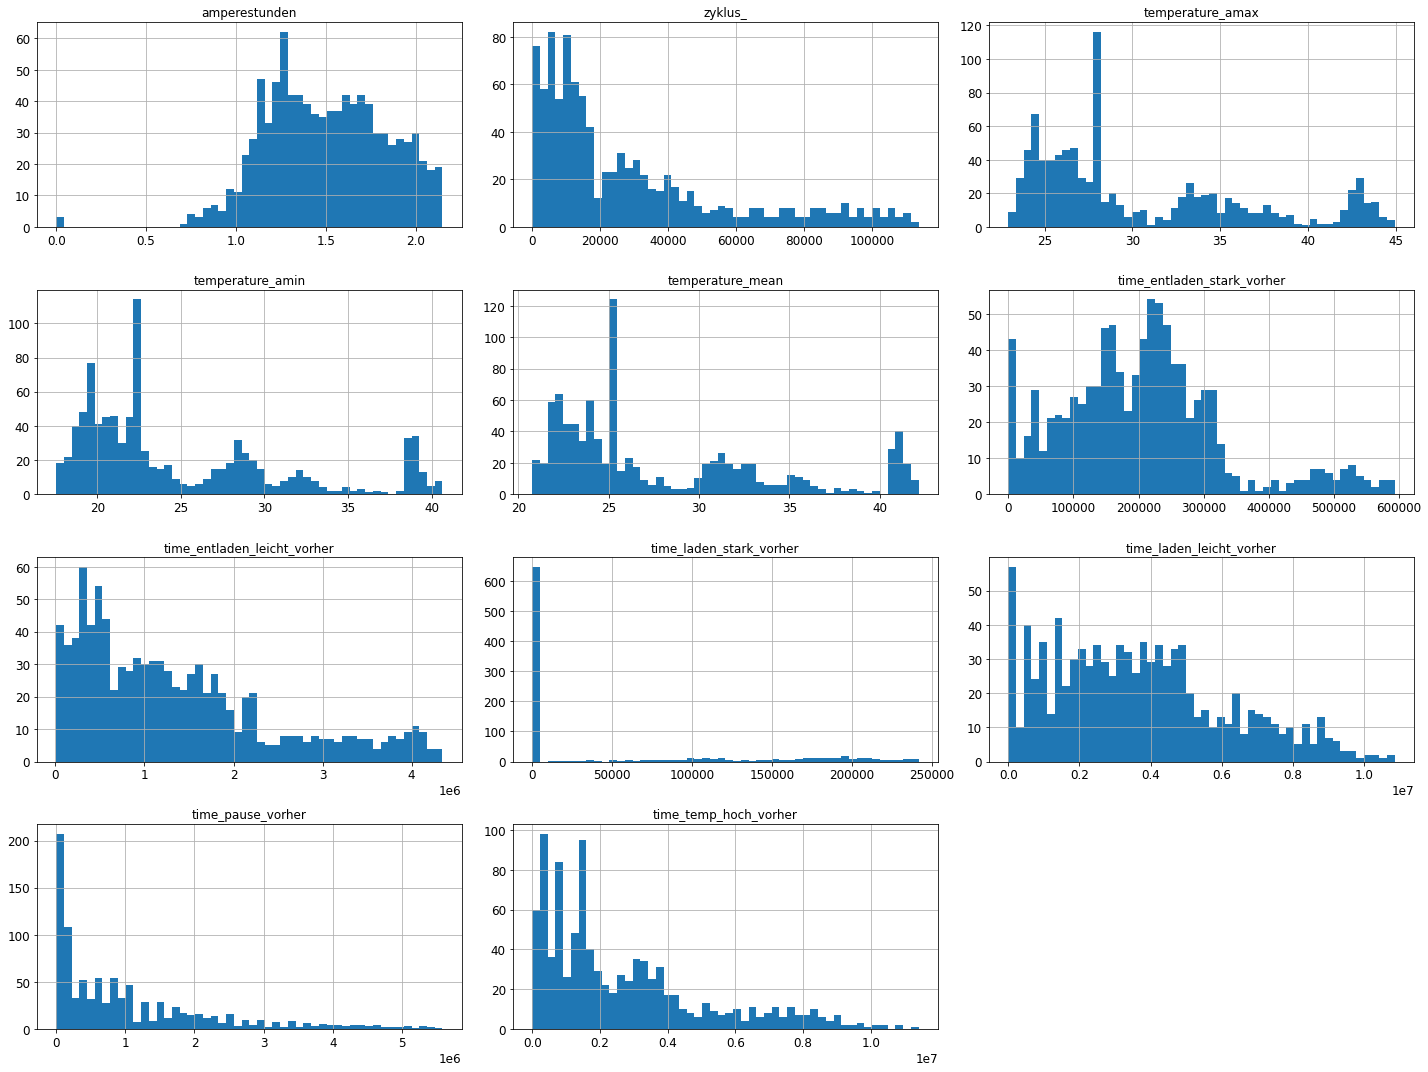

In [9]:
daten_ohne_aus.hist(bins=50, figsize=(20,15))
fu.save_fig("features_histogram_plots_ohne_ausreißer")
plt.show()

# Modellierung des Machine Learnings

## Korrelationen mit "amperestunden"
Welche der Features korrellieren am meisten mit der Zielvariablen? Wie schneiden die neu generierten Features ab? 

Saving figure features_korrelationen_mit_amperestunden


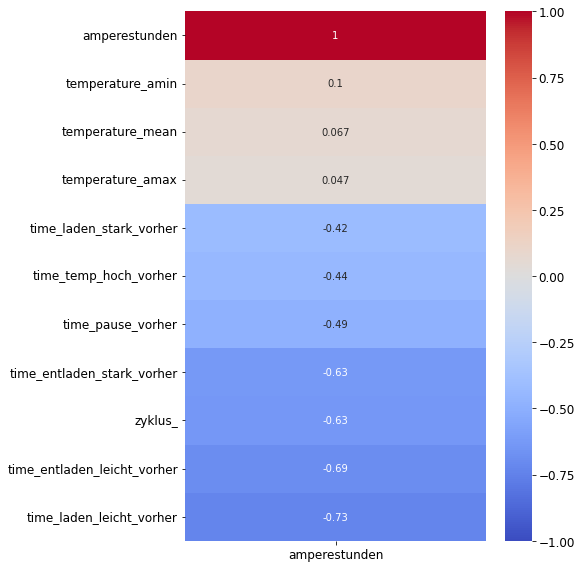

In [25]:
correlation = daten_ohne_aus.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation[["amperestunden"]].sort_values(by=['amperestunden'], ascending=False), vmin=-1, cmap='coolwarm', annot=True)
fu.save_fig("features_korrelationen_mit_amperestunden")

# Train Test Split

In [11]:
train_set, test_set = train_test_split(daten_ohne_aus, test_size=0.2, random_state=42)

daten = train_set.drop("amperestunden", axis=1)
daten_labels = train_set["amperestunden"].copy()


test_daten = train_set.drop("amperestunden", axis=1)
test_daten_labels = train_set["amperestunden"].copy()

# Null Werte -> Keine

Saving figure null_werte_in_daten


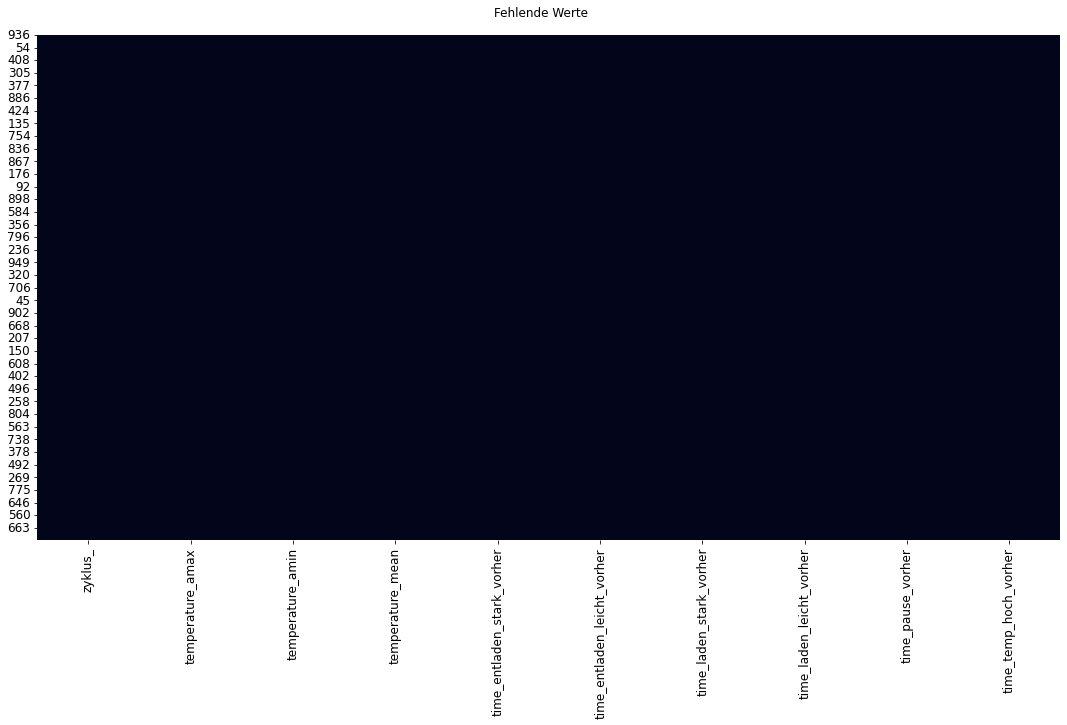

In [12]:
fig, axes = plt.subplots(1, figsize=(15, 8), sharey = False)
fig.suptitle('Fehlende Werte')
fu.save_fig("null_werte_in_daten")

sns.heatmap( data = daten.isnull(), cbar = False)
plt.draw()

# Transform-Pipeline

In [13]:
num_pipeline = Pipeline([
('std_scaler', StandardScaler()), #Warum Standard Scaler? keine Normalverteilung in den Daten
])

num_attribs = list(daten.columns)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
    ])

daten_tr = full_pipeline.fit_transform(daten)

# Hyperparameter - beste Suchen mit RandomizedSearchCV

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rfr_pm     = RandomForestRegressor()

params = {'n_estimators': range(100,1500),
          'n_jobs':       [-1],
          'criterion':    ['squared_error','absolute_error'],
          'max_depth':    range(1,200)
         }
k      = 3

reg_search = RandomizedSearchCV(rfr_pm, params, scoring= 'neg_root_mean_squared_error', cv = k, verbose = 1, n_iter=200)

In [15]:
%%time
reg_search.fit(daten_tr, daten_labels)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Wall time: 12min 45s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=200,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': range(1, 200),
                                        'n_estimators': range(100, 1500),
                                        'n_jobs': [-1]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [16]:
print(reg_search.best_params_)

{'n_jobs': -1, 'n_estimators': 202, 'max_depth': 142, 'criterion': 'squared_error'}


In [17]:
pd.DataFrame(reg_search.cv_results_).sort_values(by = ['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.220818,0.007125,0.034245,0.001764,-1,202,142,squared_error,"{'n_jobs': -1, 'n_estimators': 202, 'max_depth...",-0.099415,-0.089165,-0.083426,-0.090669,0.006613,1
179,0.219703,0.009626,0.040972,0.001948,-1,203,173,squared_error,"{'n_jobs': -1, 'n_estimators': 203, 'max_depth...",-0.100171,-0.091777,-0.082128,-0.091359,0.007372,2
75,0.246344,0.006388,0.036322,0.004433,-1,215,46,squared_error,"{'n_jobs': -1, 'n_estimators': 215, 'max_depth...",-0.095369,-0.099433,-0.079688,-0.091497,0.008513,3
182,0.720462,0.024304,0.103874,0.004690,-1,719,128,squared_error,"{'n_jobs': -1, 'n_estimators': 719, 'max_depth...",-0.095134,-0.095118,-0.084478,-0.091577,0.005020,4
56,0.794892,0.040821,0.130348,0.000134,-1,888,183,squared_error,"{'n_jobs': -1, 'n_estimators': 888, 'max_depth...",-0.099133,-0.092389,-0.083677,-0.091733,0.006327,5


# bestes Modell wegschreiben

In [18]:
prepare_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('rfr_reg', reg_search.best_estimator_)
])

In [19]:
import joblib
joblib.dump(prepare_and_predict_pipeline, "pickle/prepare_and_predict_pipeline.pkl")

['pickle/prepare_and_predict_pipeline.pkl']

In [20]:
import joblib
prepare_and_predict_pipeline_load = joblib.load("pickle/prepare_and_predict_pipeline.pkl")

# Vorhersage Test-Daten

In [21]:
test_daten_pred = prepare_and_predict_pipeline_load.predict(test_daten)
test_daten_pred_series = pd.Series(test_daten_pred, index=test_daten_labels.index)

Saving figure vergleich_rfr_prediction_mit_tatsächlichen_werten


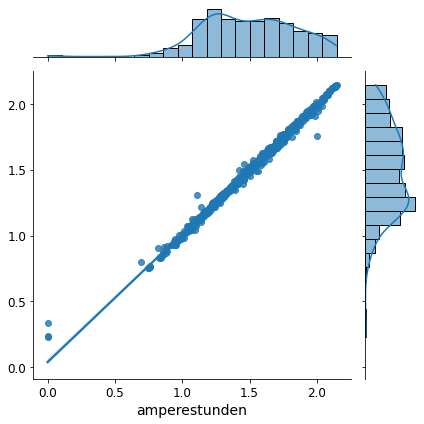

In [26]:
sns.jointplot(x=test_daten_labels,y=test_daten_pred_series, kind='reg')
fu.save_fig("vergleich_rfr_prediction_mit_tatsächlichen_werten")

In [23]:
from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_daten_labels, test_daten_pred_series)))
print('R2:',metrics.r2_score(test_daten_labels, test_daten_pred_series))

RMSE: 0.026466707380076823
R2: 0.9938291275736216


# Wichtigkeit Features

In [24]:
sorted(zip(reg_search.best_estimator_.feature_importances_, daten.columns), reverse=True)

[(0.47115149039144133, 'time_laden_leicht_vorher'),
 (0.17486546789891555, 'time_entladen_leicht_vorher'),
 (0.16979097205621912, 'time_entladen_stark_vorher'),
 (0.0707657727758595, 'time_laden_stark_vorher'),
 (0.05752414913954887, 'zyklus_'),
 (0.018701780213347084, 'time_temp_hoch_vorher'),
 (0.017192468026388352, 'time_pause_vorher'),
 (0.01144669028638974, 'temperature_amin'),
 (0.004352832073489065, 'temperature_amax'),
 (0.004208377138401348, 'temperature_mean')]

# Ent-/Laden und Anzahl an Wechsel sind wichtig

Sowohl in der Korrelation und von dem RFR werden die folgenden 5 Featrues als Wichtig angesehen:
* time_laden_leicht_vorher
* time_laden_stark_vorher
* time_entladen_leicht_vorher
* time_entladen_stark_vorher
* zyklus_

## offene Frage: Wie groß ist der Einfluss auf die Amperestunden? Um wie viel sinken die Amperestunden bei einer Minute der unterschiedlichen Verwendungen? Um wie viel ein Wechsel der Verwendung?
#### dies kann mit einer klassischen Regression und den zugehörigen Regressionskoeffizienten bestimmt werden: